# Application: Model

## Case study: Houses for sale

In this tutorial, we will build a model with the Python [`scikit-learn`](https://scikit-learn.org/stable/) module. Additionally, you will learn how to create a data preprocessing pipline.

## Setup

# Data preparation

See notebook `10a-application-model-data-exploration.ipynb` for details about data preprocessing and data exploration.

In [112]:

import pandas as pd

ROOT = "https://raw.githubusercontent.com/kirenz/modern-statistics/main/data/"
DATA = "duke-forest.csv"
df = pd.read_csv(ROOT + DATA)

# Drop irrelevant features
df = df.drop(['url', 'address', 'type'], axis=1)

# Convert data types
df['heating'] = df['heating'].astype("category")
df['cooling'] = df['cooling'].astype("category")
df['parking'] = df['parking'].astype("category")

# drop column with too many missing values
df = df.drop(['hoa'], axis=1)

df.columns.tolist()

['price',
 'bed',
 'bath',
 'area',
 'year_built',
 'heating',
 'cooling',
 'parking',
 'lot']

# Creation of data preprocessing pipeline

In [113]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data preprocessing pipeline

# for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

# Simple regression

In [114]:
# Select features for simple regression
features = ['area']
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   area    98 non-null     int64
dtypes: int64(1)
memory usage: 912.0 bytes
Missing values: 0


## Data splitting

In [115]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [116]:
from sklearn.linear_model import LinearRegression

# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [117]:
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb30fe5d090>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
          

In [118]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([155120.6689059])

## Evaluation with training data

There are various options to evaluate a model in scikit-learn. Review this overview about [metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [155]:
X_train.head()

,area
49,2902
70,2637
68,1661
15,2750
39,2334


In [119]:
y_pred = lm_pipe.predict(X_train)

In [157]:
y_pred

array([ 435782.86538607,  355750.56913075,  455113.4651588 ,
        755008.75135255,  650948.70023954,  924467.65403312,
        947050.13040313,  439757.38122719,  440660.68028199,
       1154086.2737634 ,  500459.07770978,  603073.85033511,
        517079.78031811,  393689.12943237,  355569.90931979,
        383030.20058572,  411935.77033934,  460352.59967664,
        438854.08217239,  492510.04602754])

In [120]:
from sklearn.metrics import r2_score

r2_score(y_train, y_pred)  

0.5560009346032928

In [121]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_pred)

19215242600.426193

In [122]:
# RMSE
mean_squared_error(y_train, y_pred, squared=False)

138619.0556901402

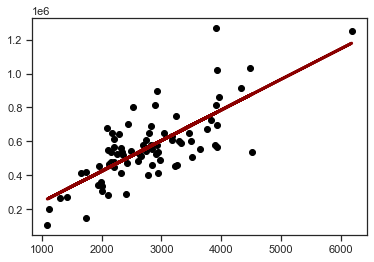

In [123]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot with matplotlib
plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, y_pred, color='darkred', linewidth=3);

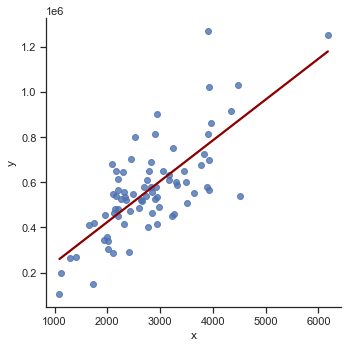

In [124]:
import seaborn as sns 
sns.set_theme(style="ticks")

# Plot with Seaborn

# We first need to create a DataFrame
df_train = pd.DataFrame({'x': X_train['area'], 'y':y_train})

sns.lmplot(x='x', y='y', data=df_train, line_kws={'color': 'darkred'}, ci=False);

In [125]:
import plotly.express as px

# Plot with Plotly Express
px.scatter(x=X_train['area'], y=y_train, opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

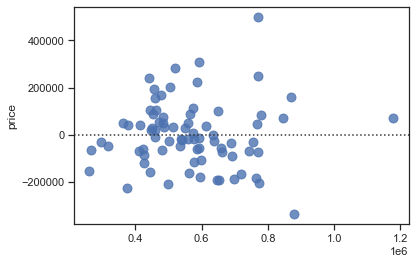

In [126]:
sns.residplot(x=y_pred, y=y_train, scatter_kws={"s": 80});

## Evaluation with test data

In [127]:
y_pred = lm_pipe.predict(X_test)

In [174]:
print('MSE:', mean_squared_error(y_test, y_pred))

print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MSE: 63888283048.62581
RMSE: 252761.31636115882


In [129]:
# Plot with Plotly Express
px.scatter(x=X_test['area'], y=y_test, opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

Model generalization on unseen data (see [plotly documentation](https://plotly.com/python/ml-regression/))


In [176]:
import numpy as np
import plotly.graph_objects as go

x_range = pd.DataFrame({ 'area': np.linspace(X_train['area'].min(), X_train['area'].max(), 100)})
y_range =  lm_pipe.predict(x_range)

go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range.area, y=y_range, name='prediction')
])


# Multiple regression

In [96]:
# Select features for multiple regression
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bed         98 non-null     int64   
 1   bath        98 non-null     float64 
 2   area        98 non-null     int64   
 3   year_built  98 non-null     int64   
 4   cooling     98 non-null     category
 5   lot         97 non-null     float64 
dtypes: category(1), float64(2), int64(3)
memory usage: 4.1 KB
Missing values: 1


In [97]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb30edc7450>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
          

In [99]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([  2447.57967471,  50670.93485383,  86499.75206383,  20145.48540648,
        64856.29369518,  25401.84101108, -25401.84101108])

In [100]:
y_pred = lm_pipe.predict(X_train)

In [101]:
r2_score(y_train, y_pred)

0.6936772829350181